In [28]:
# Parameters
artificial_humans = {
    'all ': {
        'contribution_model': "../../artifacts/artificial_humans/04_3_model/model/architecture_node+edge+rnn.pt",
        'valid_model': "../../artifacts/artificial_humans/02_3_valid/model/rnn_True.pt"
    },
    'human managed ': {
        'contribution_model': "../../artifacts/artificial_humans/03_dataset/model/dataset_human_manager.pt",
        'valid_model': "../../artifacts/artificial_humans/02_2_valid/model/rnn_True.pt"
    },
}
managers = {
    "humanlike": {
        "type": "human",
        "path": "../../artifacts/human_like_manager/05_2_model/model/architecture_node+edge.pt",
    },
    "optimal": {
        "type": "rl",
        "path": "../../artifacts/manager_v3/17_model3/model/architecture_node+edge+rnn__run_0.pt",
    },
}
output_path = "../../data/manager/simulate_rule/v1_comp/"
n_episode_steps = 16
n_episodes = 500


In [29]:
%load_ext autoreload
%autoreload 2

import os
import torch as th
import numpy as np
import seaborn as sns
import pandas as pd
from itertools import count
from aimanager.utils.utils import make_dir

from aimanager.manager.memory_v1 import Memory
from aimanager.manager.environment import ArtificialHumanEnv

from aimanager.manager.api_manager import MultiManager
from aimanager.artificial_humans import GraphNetwork
from aimanager.utils.array_to_df import using_multiindex, add_labels

output_path = os.path.join(output_path, 'data')

plot_folder = f'plots/simulate_mixed'

make_dir(plot_folder)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
def mem_to_df(recorder, name):
    columns = ['episode','round_number','participant_code']

    punishments = using_multiindex(recorder.memory['punishments'].numpy(), columns=columns, value_name='punishment')
    common_good = using_multiindex(recorder.memory['common_good'].numpy(), columns=columns, value_name='common_good')
    contributions = using_multiindex(recorder.memory['contributions'].numpy(), columns=columns, value_name='contribution')

    df_sim = punishments.merge(common_good).merge(contributions)

    df_sim['participant_code'] = df_sim['participant_code'].astype(str) + '_' + df_sim['episode'].astype(str)

    df_sim['run'] = name
    return df_sim

def make_round(contributions, groups, round):
    return {
        'contributions': contributions,
        'missing_inputs': [c is None for c in contributions],
        'manager_missing_inputs': [True] * len(contributions),
        'punishments': [None] * len(contributions),
        'groups': groups,
        'round': round,
    }

def add_punishments(round, punishments):
    return {
        **round,
        'punishments': punishments,
        'manager_missing_inputs': [p is None for p in punishments],
    }


In [31]:
device = th.device('cpu')
rec_device = th.device('cpu')
mm = MultiManager(managers)

runs = {
    f"ah {h}managed by {m}": {'groups': [m]*4, 'humans': h}
    for m in managers.keys()
    for h in artificial_humans.keys()
}

dfs = []
for name, run in runs.items():
    print(f'Start run {name}')
    groups = run['groups']
    n_agents = len(groups)
    ah = GraphNetwork.load(artificial_humans[run['humans']]['contribution_model'], device=device)
    ah_val = GraphNetwork.load(artificial_humans[run['humans']]['valid_model'], device=device)
    env = ArtificialHumanEnv(
        artifical_humans=ah, 
        artifical_humans_valid=ah_val, 
        n_agents=n_agents, n_contributions=21, n_punishments=31, 
        n_rounds=n_episode_steps, batch_size=1, device=device)
    recorder = Memory(
        n_episodes=n_episodes, n_episode_steps=n_episode_steps, output_file=None, device=device)
    for e in range(n_episodes):
        state = env.reset()
        rounds = []
        for round_number in count():
            contributions = state['contributions'].squeeze().tolist()
            round = make_round(contributions, groups, round_number)
            punishments = mm.get_punishments(rounds+[round])[0]
            round = add_punishments(round, punishments)
            rounds.append(round)
            punishments = th.tensor(punishments, dtype=th.int64)
            state = env.punish(punishments.unsqueeze(-1))
            recorder.add(
                **{k: v.squeeze(-1) for k, v in state.items()}, 
                episode_step=round_number)
            state, reward, done = env.step()
            if done:
                break
        recorder.next_episode(e)
    dfs.append(mem_to_df(recorder, name=name))
   

Start run ah all managed by humanlike
Start run ah human managed managed by humanlike
Start run ah all managed by optimal
Start run ah human managed managed by optimal


In [32]:
data_file = "../../data/experiments/pilot_random1_player_round_slim.csv"

df_pilot = pd.read_csv(data_file)

experiment_name_map = {
    'trail_rounds_2': 'pilot human manager',
    'random_1': 'pilot rule based manager'
}

df_pilot['run'] = df_pilot['experiment_name'].map(experiment_name_map)
df_pilot['common_good'] = df_pilot['common_good'] / 4
df_pilot = df_pilot[['round_number', 'common_good', 'contribution', 'participant_code', 'punishment', 'run']]

df = pd.concat([*dfs, df_pilot]).reset_index(drop=True)

dfm = df.melt(
    id_vars=['round_number', 'participant_code', 'run'], 
    value_vars=['punishment', 'contribution', 'common_good'])

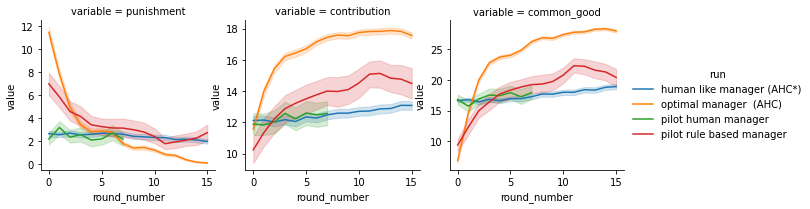

In [51]:
w = dfm['run'].isin([
    'ah all managed by optimal',
    'ah human managed managed by humanlike',
    'pilot human manager',
    'pilot rule based manager',
])

dfg = dfm[w].copy()
dfg['run'] = dfg['run'].map({
    'ah all managed by optimal': 'optimal manager  (AHC)',
    'ah human managed managed by humanlike': 'human like manager (AHC*)',
    'pilot human manager': 'pilot human manager',
    'pilot rule based manager': 'pilot rule based manager'
})


g = sns.relplot(
    data=dfg,
    x="round_number", 
    y="value",
    col='variable',
    hue='run',
    kind="line",
    facet_kws={'sharey': False, 'sharex': True},
    height=3, aspect=1,
)

g.savefig(os.path.join(plot_folder, 'comparison_pilot.jpg'))


In [34]:
dfm['run'].unique()

array(['ah all managed by humanlike',
       'ah human managed managed by humanlike',
       'ah all managed by optimal', 'ah human managed managed by optimal',
       'pilot human manager', 'pilot rule based manager'], dtype=object)

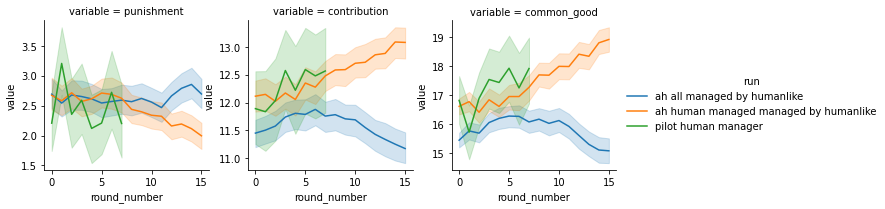

In [49]:
w = dfm['run'].isin([
    'ah human managed managed by humanlike',
    'ah all managed by humanlike',
    'pilot human manager',
])

g = sns.relplot(
    data=dfm[w],
    x="round_number", 
    y="value",
    col='variable',
    hue='run',
    kind="line",
    facet_kws={'sharey': False, 'sharex': True},
    height=3, aspect=1,
)

g.savefig(os.path.join(plot_folder, 'comparison_pilot_hm.jpg'))

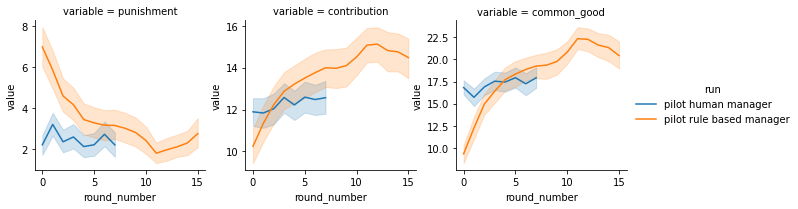

In [46]:

w = dfm['run'].isin([
    'ah all managed managed by optimal',
    'pilot human manager',
    'pilot rule based manager'
])

g = sns.relplot(
    data=dfm[w],
    x="round_number", 
    y="value",
    col='variable',
    hue='run',
    kind="line",
    facet_kws={'sharey': False, 'sharex': True},
    height=3, aspect=1,
)

g.savefig(os.path.join(plot_folder, 'comparison_pilot_om.jpg'))

ah all managed by humanlike vs. pilot human manager: Mann-Whitney-Wilcoxon test two-sided, P_val:1.541e-01 U_stat=2.023e+05
ah human managed managed by humanlike vs. pilot human manager: Mann-Whitney-Wilcoxon test two-sided, P_val:7.679e-01 U_stat=2.124e+05


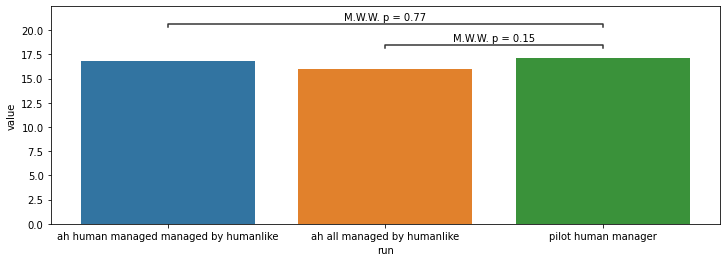

In [48]:
from statannotations.Annotator import Annotator
import matplotlib.pyplot as plt

order = ['ah human managed managed by humanlike', 'ah all managed by humanlike', 'pilot human manager']

w = (
    (dfm['round_number'] < 8) &
    (dfm['variable'] == 'common_good') &
    (dfm['run'].isin(order))
)

dfg = dfm[w].groupby(['participant_code', 'run', 'variable'])["value"].mean().reset_index()

pairs = [[order[0], order[2]], [order[1], order[2]]]

plt.figure(figsize=(12,4))

ax = sns.barplot(
    data=dfg,
    order=order,
    x="run", 
    y="value",
    errorbar=None
)

annotator = Annotator(ax, pairs, data=dfg, x='run', y='value', order=order)
annotator.configure(test='Mann-Whitney', text_format='simple', loc='inside')
annotator.apply_and_annotate()

plt.savefig(os.path.join(plot_folder, 'comparison_pilot_bar.jpg'))


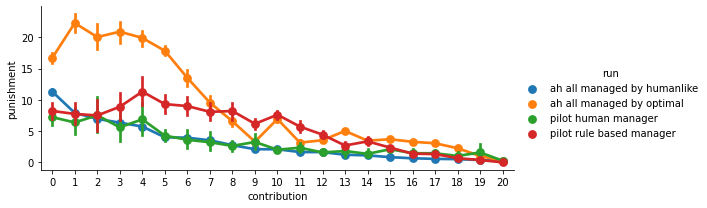

In [38]:
df['contribution'] = df['contribution'].astype(int)


w = df['run'].isin([
    'ah all managed by humanlike',
    'ah all managed by optimal',
    'pilot human manager',
    'pilot rule based manager'
])


g = sns.catplot(
    data=df[w],
    x="contribution", 
    y="punishment",
    hue='run',
    kind="point",
    height=3, aspect=2.5,
)

g.savefig(os.path.join(plot_folder, 'comparison_pilot_policy.jpg'))

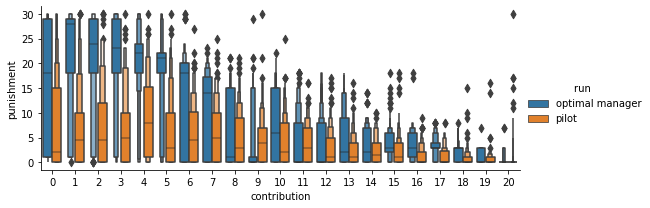

In [39]:
df['contribution'] = df['contribution'].astype(int)

df['run '] = df['run']
df['run '] = df['run'].map({
    'pilot human manager': 'pilot',
    'pilot rule based manager': 'pilot',
    'ah all managed by optimal': 'optimal manager'
})

g = sns.catplot(
    data=df[w],
    x="contribution", 
    y="punishment",
    hue='run ',
    kind="boxen",
    height=3, aspect=2.5,
)

g.savefig(os.path.join(plot_folder, 'comparison_pilot_policy_box.jpg'))